## Импорт библиотек

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import gc
import numpy as np
import optuna
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

C:\Users\shish\anaconda3\envs\new_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Загрузка и преобразование датасетов

### Загрузка и преобразование паркетов

In [2]:
def main_df_load(x):
    df = pd.DataFrame()
    
    for i in range(x):
        temp_df = pd.read_parquet(f'train_data/train_data_{i}.pq')
        for col in temp_df.columns:
            if np.all((temp_df[col] >= np.iinfo(np.int8).min) & (temp_df[col] <= np.iinfo(np.int8).max)):
                temp_df[col] = temp_df[col].astype('int8')
            
        df = pd.concat([df, temp_df])
        
        del temp_df
    return df

In [3]:
df = main_df_load(12)

In [4]:
df.shape

(26162717, 61)

### Удаление дубликатов

In [5]:
def drop_duplicates(df):
    df = df.drop_duplicates()
    return df

In [6]:
df = drop_duplicates(df)

In [7]:
df.shape

(26162717, 61)

### Удаление пустых строк

In [8]:
def drop_nan(df):
    df = df.dropna()
    return df

In [9]:
df = drop_nan(df)

In [10]:
df.shape

(26162717, 61)

### Кодировка категориальных переменных

In [11]:
def encoding(df):
    cols_for_encoder = df.drop(['id', 'rn', 'is_zero_loans5', 'is_zero_loans530', 
                                 'is_zero_loans3060', 'is_zero_loans6090', 
                                 'is_zero_loans90', 'is_zero_util', 
                                 'is_zero_over2limit', 'is_zero_maxover2limit', 
                                 'pclose_flag', 'fclose_flag'], axis=1).columns.tolist()

    df = pd.get_dummies(df, columns=cols_for_encoder, dtype='int8')
    return df

In [12]:
df = encoding(df)

In [13]:
df.shape

(26162717, 411)

### Агрегация

In [14]:
def agg_func(df):
    max_columns = ['rn']
    sum_columns = df.drop(['id', 'rn'], axis=1).columns.tolist()

    agg_dict = {col: 'max' for col in max_columns}
    agg_dict.update({col: 'sum' for col in sum_columns})

    df = df.groupby('id', as_index=False).agg(agg_dict)

    for col in df.columns:
        if col != 'id':
            if np.all((df[col] >= np.iinfo(np.int8).min) & (df[col] <= np.iinfo(np.int8).max)):
                df[col] = df[col].astype('int8')
            elif np.all((df[col] >= np.iinfo(np.int16).min) & (df[col] <= np.iinfo(np.int16).max)):
                df[col] = df[col].astype('int16')
            else:
                df[col] = df[col].astype('int32')
    return df

In [15]:
df = agg_func(df)

In [16]:
df.shape

(3000000, 411)

### Объединение с целевой переменной

In [17]:
def merge_targets(df):
    target_df = pd.read_csv('target/train_target.csv')
    df = df.merge(target_df, on='id', how='inner')
    del target_df
    return df

In [18]:
df = merge_targets(df)

In [19]:
df.shape

(3000000, 412)

### Генерация новых признаков

In [20]:
def new_features(df):
    for col in df.drop(['id', 'rn', 'flag'], axis=1).columns.tolist():
        df.loc[:, [f'{col}_to_rn']] = df[col] / df['rn']
        if np.all((df[f'{col}_to_rn'] >= np.finfo(np.float16).min) & (df[f'{col}_to_rn'] <= np.finfo(np.float16).max)):
            df[f'{col}_to_rn'] = df[f'{col}_to_rn'].astype('float16')
        else:
            df[f'{col}_to_rn'] = df[f'{col}_to_rn'].astype('float32')
    return df

In [21]:
df = new_features(df)

In [22]:
df.shape

(3000000, 821)

### Удаление ненужных столбцов

In [23]:
def drop_columns(df):
    df = df.drop('id', axis=1)
    return df

In [24]:
df = drop_columns(df)

In [25]:
df.shape

(3000000, 820)

In [26]:
df.to_pickle('data_4Modeling.pkl')

### Разделение данных для моделирования

In [27]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
x_train = df_train.drop('flag', axis=1)
y_train = df_train['flag']

x_test = df_test.drop('flag', axis=1)
y_test = df_test['flag']

In [28]:
len(y_train[y_train == 0]) / len(y_train[y_train == 1])

27.19383259911894

## Моделирование

### Моделирование с параметрами по умолчанию

In [43]:
models = [RandomForestClassifier(class_weight='balanced'), 
          LogisticRegression(class_weight='balanced'), 
          LGBMClassifier(verbose=0, class_weight='balanced'), 
          CatBoostClassifier(verbose=0, class_weights=[1, 30])]
model_metrics = []
for model in models:
    model.fit(x_train, y_train)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')

    y_pred = model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

    model_metrics.append({
        'model': (f'{model}'),
        'cv_mean_roc_auc': round(cv_scores.mean(), 3),
        'accuracy': round(accuracy, 3),
        'precision_score': round(precision, 3),
        'recall': round(recall, 3),
        'f1': round(f1, 3),
        'roc_auc': round(roc_auc, 3)
    })

result_df = pd.DataFrame(model_metrics)

In [45]:
result_df

,model,cv_mean_roc_auc,accuracy,precision_score,recall,f1,roc_auc
0,RandomForestClassifier(class_weight='balanced'),0.706,0.969,0.188,0.006,0.012,0.707
1,LogisticRegression(class_weight='balanced'),0.764,0.711,0.067,0.661,0.121,0.753
2,"LGBMClassifier(class_weight='balanced', verbos...",0.762,0.747,0.072,0.620,0.129,0.755
3,<catboost.core.CatBoostClassifier object at 0x...,0.732,0.874,0.093,0.361,0.148,0.729


### Тюнинг моделей

#### LGBM Model

In [46]:
def lgbm_tuning(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'verbose': -1,
        'class_weight': 'balanced',
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1)
    }
    
    model = LGBMClassifier(**params)
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)])
    
    y_pred = model.predict_proba(x_test)[:, 1]
    score = roc_auc_score(y_test, y_pred)
    return score

In [47]:
study = optuna.create_study(direction='maximize')
study.optimize(lgbm_tuning, n_trials=30)

lgbm_best_params = study.best_params
print(f'Лучшие гиперпараметры: {lgbm_best_params}')

[I 2025-02-02 19:07:40,850] A new study created in memory with name: no-name-3589f927-bac7-4a74-b2e5-88dee2c3c8b6
[I 2025-02-02 19:08:37,833] Trial 0 finished with value: 0.744640924311789 and parameters: {'learning_rate': 0.09244955036989178, 'n_estimators': 288, 'reg_alpha': 0.40129954301310866, 'reg_lambda': 0.677440405948118}. Best is trial 0 with value: 0.744640924311789.
[I 2025-02-02 19:09:06,904] Trial 1 finished with value: 0.7437878171390377 and parameters: {'learning_rate': 0.1802003950243681, 'n_estimators': 102, 'reg_alpha': 0.8364565256457746, 'reg_lambda': 0.9052952456943255}. Best is trial 0 with value: 0.744640924311789.
[I 2025-02-02 19:09:45,474] Trial 2 finished with value: 0.7395791009468276 and parameters: {'learning_rate': 0.15858361221771275, 'n_estimators': 176, 'reg_alpha': 0.20500152598271304, 'reg_lambda': 0.6612644479321779}. Best is trial 0 with value: 0.744640924311789.
[I 2025-02-02 19:10:30,404] Trial 3 finished with value: 0.7559724292336788 and parame

Лучшие гиперпараметры: {'learning_rate': 0.05247154720241421, 'n_estimators': 133, 'reg_alpha': 0.815390925213284, 'reg_lambda': 0.7700898756050937}


#### Catboost Model

In [48]:
def catboost_tuning(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'random_strength': trial.suggest_uniform('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'od_type': 'Iter',
        'od_wait': 20,
        'eval_metric': 'AUC',
        'class_weights': {0: 1.0, 1: 30.0}}
    
    model = CatBoostClassifier(**params)
    model.fit(
        x_train, y_train,
        eval_set=(x_test, y_test),
        use_best_model=True,
        verbose=0)
    
    y_pred = model.predict_proba(x_test)[:, 1]
    score = roc_auc_score(y_test, y_pred)
    
    return score

In [49]:
study = optuna.create_study(direction='maximize')
study.optimize(catboost_tuning, n_trials=30)

catboost_best_param = study.best_params
print(f'Лучшие гиперпараметры: {catboost_best_param}')

[I 2025-02-02 19:38:59,974] A new study created in memory with name: no-name-8ea16d85-9500-47c4-940b-20c9c208f86e
[I 2025-02-02 19:54:22,363] Trial 0 finished with value: 0.7138859702212784 and parameters: {'iterations': 221, 'depth': 12, 'learning_rate': 0.0021744849781385766, 'l2_leaf_reg': 0.2291534356948615, 'random_strength': 9.33329420337949, 'bagging_temperature': 0.4486210237712537}. Best is trial 0 with value: 0.7138859702212784.
[I 2025-02-02 19:56:01,905] Trial 1 finished with value: 0.7039038881402331 and parameters: {'iterations': 351, 'depth': 6, 'learning_rate': 0.0012988411487768446, 'l2_leaf_reg': 0.0036821866092307184, 'random_strength': 6.0367962777276185, 'bagging_temperature': 0.20799427414805005}. Best is trial 0 with value: 0.7138859702212784.
[I 2025-02-02 20:14:57,203] Trial 2 finished with value: 0.7376825618571797 and parameters: {'iterations': 360, 'depth': 10, 'learning_rate': 0.004224608818119142, 'l2_leaf_reg': 0.3803053230577157, 'random_strength': 0.380

Лучшие гиперпараметры: {'iterations': 412, 'depth': 4, 'learning_rate': 0.06331467163380282, 'l2_leaf_reg': 3.2847117601301244e-07, 'random_strength': 7.409689871434082, 'bagging_temperature': 0.5329288099849571}


#### Выбор финальной модели

In [29]:
lgbm_best_params = {'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'verbose': 0,
                    'class_weight': 'balanced',
                    'learning_rate': 0.05247154720241421,
                    'n_estimators': 133,
                    'reg_alpha': 0.815390925213284,
                    'reg_lambda': 0.7700898756050937}


catboost_best_params = {'iterations': 412,
                        'depth': 4,
                        'learning_rate': 0.06331467163380282,
                        'l2_leaf_reg': 3.2847117601301244e-07,
                        'random_strength': 7.409689871434082,
                        'bagging_temperature': 0.5329288099849571,
                        'od_type': 'Iter',
                        'od_wait': 20,
                        'eval_metric': 'AUC',
                        'class_weights': {0: 1.0, 1: 30.0},
                        'verbose': 0}

In [52]:
models = [LGBMClassifier(**lgbm_best_params), 
          CatBoostClassifier(**catboost_best_params)]

for model in models:
    model.fit(x_train, y_train)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')

    y_pred = model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

    model_metrics.append({
        'model': (f'{model}_tuned'),
        'cv_mean_roc_auc': round(cv_scores.mean(), 3),
        'accuracy': round(accuracy, 3),
        'precision_score': round(precision, 3),
        'recall': round(recall, 3),
        'f1': round(f1, 3),
        'roc_auc': round(roc_auc, 3)
    })

result_df = pd.DataFrame(model_metrics)

In [57]:
result_df

,model,cv_mean_roc_auc,accuracy,precision_score,recall,f1,roc_auc
0,RandomForest_default,0.706,0.969,0.188,0.006,0.012,0.707
1,LogisticRegression_default,0.764,0.711,0.067,0.661,0.121,0.753
2,LightGBMClassifier_default,0.762,0.747,0.072,0.620,0.129,0.755
3,CatboostClassifier_default,0.732,0.874,0.093,0.361,0.148,0.729
5,LightGBMClassifier_tuned,0.766,0.732,0.071,0.652,0.128,0.761
6,CatboostClassifier_tuned,0.760,0.735,0.070,0.629,0.126,0.755


### Модель на полном объеме данных

In [31]:
final_lgbm_best_params = {
        'learning_rate': 0.08,
        'n_estimators': 300,
        'reg_alpha': 0.1,
        'reg_lambda': 0.4,
        'metric': 'auc',
        'class_weight': 'balanced',
        'verbose': 0
    }

In [32]:
model = LGBMClassifier(**final_lgbm_best_params)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
    
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

              precision    recall  f1-score   support

           0       0.98      0.68      0.80    578683
           1       0.08      0.71      0.14     21317

    accuracy                           0.68    600000
   macro avg       0.53      0.69      0.47    600000
weighted avg       0.95      0.68      0.78    600000

Accuracy: 0.680
Precision: 0.075
Recall: 0.708
F1 Score: 0.136
ROC AUC: 0.762


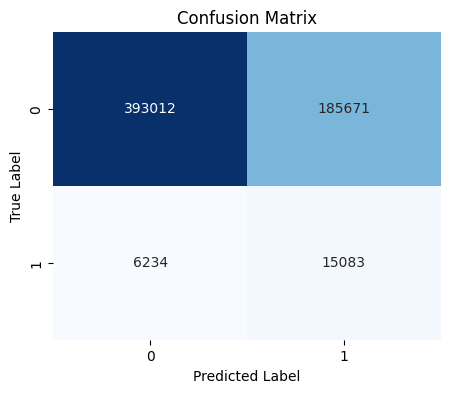

In [33]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

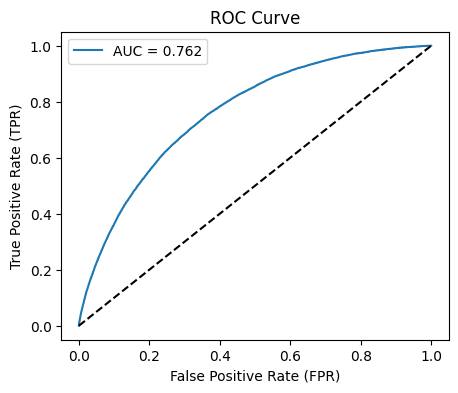

In [34]:
probs = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

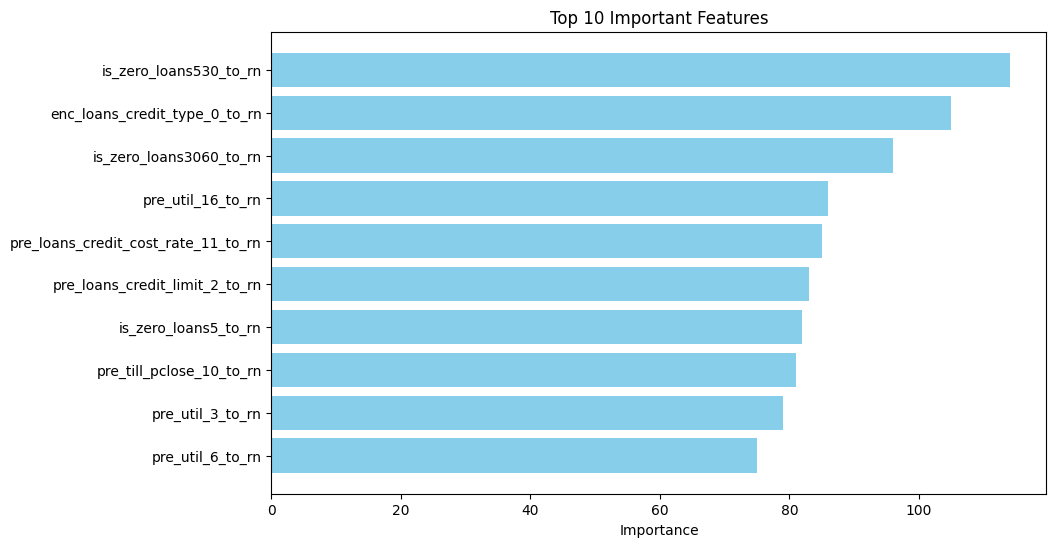

In [35]:
feature_importances = model.feature_importances_
feature_names = x_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_10_features = importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis() 
plt.show()

In [62]:
result_df.to_csv('df_result_metrics.csv', index=False)